# 시계열 데이터 MICE 처리 및 AutoGluon 모델링

이 노트북은 시계열 데이터의 결측치를 MICE로 처리하고 AutoGluon으로 예측 모델을 구축하는 과정을 다룹니다.

In [1]:
!pip install autogluon

  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
Using cached packaging-24.2-py3-none-any.whl (65 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)

  Attempting uninstall: packaging

    Found existing installation: packaging 25.0

    Uninstalling packaging-25.0:

      Successfully uninstalled packaging-25.0

  Attempting uninstall: scikit-learn

    Found existing installation: scikit-learn 1.3.0

   -------------------- ------------------- 1/2 [scikit-learn]
    Uninstalling scikit-learn-1.3.0:
   -------------------- ------------------- 1/2 [scikit-learn]
      Successfully uninstalled scikit-learn-1.3.0
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   ------------

In [2]:
# 필요한 라이브러리 설치
!pip install autogluon scikit-learn pandas numpy matplotlib seaborn
!pip install impyute

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from autogluon.tabular import TabularDataset, TabularPredictor
import warnings
warnings.filterwarnings('ignore')

# 시드 설정
np.random.seed(42)

c:\Users\dlsxk\Python_Projects\heat_demand\MyProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 데이터 로딩 및 탐색

In [6]:
train_data = pd.read_csv("train_data_mice.csv")
test_data = pd.read_csv("test_data_mice.csv")

print(f"Train 데이터 크기: {len(train_data)}")
print(f"Test 데이터 크기: {len(test_data)}")

Train 데이터 크기: 332861
Test 데이터 크기: 166440


## 2. AutoGluon 모델링

In [7]:
# AutoGluon용 데이터 준비
# 예측 변수 설정 (target을 예측한다고 가정)
target_col = 'heat_demand'
# feature_columns = ['feature1', 'feature2', 'feature3', 'year', 'month', 'day', 'dayofweek', 'dayofyear']

# AutoGluon 데이터셋 생성
train_ag = train_data
# train_data_imputed[feature_columns + [target_col]]
test_ag = test_data
# test_data_imputed[feature_columns + [target_col]]

print("AutoGluon 학습 데이터 shape:", train_ag.shape)
print("AutoGluon 테스트 데이터 shape:", test_ag.shape)

# TabularDataset으로 변환
train_dataset = TabularDataset(train_ag)
test_dataset = TabularDataset(test_ag)

print("\n학습 데이터 미리보기:")
train_dataset.head()

AutoGluon 학습 데이터 shape: (332861, 21)
AutoGluon 테스트 데이터 shape: (166440, 21)

학습 데이터 미리보기:


,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,...,year,month,day,hour,dayofweek,dayofyear,week,is_weekend,time_period,heating_season
0,2021-01-01 01:00:00,1.0,0.166957,0.238443,0.042017,0.0,0.0,0.673846,0.0,0.266990,...,2021.0,1.0,1.0,1.0,4.0,1.0,53.0,0.0,3.0,1.0
1,2021-01-01 02:00:00,1.0,0.165217,0.221141,0.050420,0.0,0.0,0.691282,0.0,0.260518,...,2021.0,1.0,1.0,2.0,4.0,1.0,53.0,0.0,3.0,1.0
2,2021-01-01 03:00:00,1.0,0.168696,1.000000,0.000000,0.0,0.0,0.684103,0.0,0.257282,...,2021.0,1.0,1.0,3.0,4.0,1.0,53.0,0.0,3.0,1.0
3,2021-01-01 04:00:00,1.0,0.180870,0.448229,0.042017,0.0,0.0,0.641026,0.0,0.255663,...,2021.0,1.0,1.0,4.0,4.0,1.0,53.0,0.0,3.0,1.0
4,2021-01-01 05:00:00,1.0,0.186087,0.227629,0.159664,0.0,0.0,0.625641,0.0,0.250809,...,2021.0,1.0,1.0,5.0,4.0,1.0,53.0,0.0,3.0,1.0


In [8]:
# AutoGluon Predictor 설정 및 학습
predictor = TabularPredictor(
    label=target_col,
    eval_metric='root_mean_squared_error',  # RMSE 평가지표 설정
    path='./autogluon_models'  # 모델 저장 경로
)

# 모델 학습
print("AutoGluon 모델 학습 시작...")
predictor.fit(
    train_dataset,
    time_limit=6000,  # 시간 제한 (필요에 따라 조정)
    presets='best_quality',  # 'medium_quality', 'high_quality', 'best_quality'
    excluded_model_types=['KNN']  # 시계열에서 KNN은 보통 제외  # 이게 무슨 의미인지 재확인하기기
)

print("모델 학습 완료!")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
Memory Avail:       14.93 GB / 31.50 GB (47.4%)
Disk Space Avail:   768.95 GB / 931.18 GB (82.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up 

AutoGluon 모델 학습 시작...


2025-06-01 22:36:55,359	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
	Running DyStack sub-fit in a ray process to avoid memory leakage. Enabling ray logging (enable_ray_logging=True). Specify `ds_args={'enable_ray_logging': False}` if you experience logging issues.
2025-06-01 22:37:08,399	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
		Context path: "c:\Users\dlsxk\Python_Projects\heat_demand\MyProject\0601_Baseline\autogluon_models\ds_sub_fit\sub_fit_ho"
(_dystack pid=10028) Running DyStack sub-fit ...
(_dystack pid=10028) Beginning AutoGluon training ... Time limit = 1479s
(_dystack pid=10028) AutoGluon will save models to "c:\Users\dlsxk\Python_Projects\heat_demand\MyProject\0601_Baseline\autogluon_models\ds_sub_fit\sub_fit_ho"
(_dystack pid=10028) Train Data Rows:    295876
(_dystack pid=10028) Train Data Columns: 20
(_dystack pid=

(_ray_fit pid=20544) [1000]	valid_set's rmse: 16.2656
(_ray_fit pid=20544) [2000]	valid_set's rmse: 14.2009 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=20544) [3000]	valid_set's rmse: 13.4974 [repeated 8x across cluster]
(_ray_fit pid=20544) [4000]	valid_set's rmse: 13.0819 [repeated 8x across cluster]
(_ray_fit pid=20544) [5000]	valid_set's rmse: 12.7925 [repeated 8x across cluster]
(_ray_fit pid=20544) [6000]	valid_set's rmse: 12.5417 [repeated 8x across cluster]
(_ray_fit pid=20544) [7000]	valid_set's rmse: 12.354 [repeated 8x across cluster]
(_ray_fit pid=20544) [8000]	valid_set's rmse: 12.2068 [repeated 8x across cluster]
(_ray_fit pid=20544) [9000]	valid_set's rmse: 12.0782 [repeated 8x across cluster]
(_ray_fit pid=27364) [10000]	valid_set's rmse: 11.7166 [repeated 8x ac

(_dystack pid=10028) 	-11.8674	 = Validation score   (-root_mean_squared_error)
(_dystack pid=10028) 	200.64s	 = Training   runtime
(_dystack pid=10028) 	564.1s	 = Validation runtime
(_dystack pid=10028) Fitting model: LightGBM_BAG_L1 ... Training model for up to 703.04s of the 1195.79s of remaining time.
(_dystack pid=10028) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=2.03%)


(_ray_fit pid=34484) [1000]	valid_set's rmse: 12.7712 [repeated 8x across cluster]
(_ray_fit pid=26980) [1000]	valid_set's rmse: 12.4608 [repeated 6x across cluster]
(_ray_fit pid=34484) [2000]	valid_set's rmse: 11.7195 [repeated 2x across cluster]
(_ray_fit pid=26980) [2000]	valid_set's rmse: 11.3802 [repeated 6x across cluster]
(_ray_fit pid=34484) [3000]	valid_set's rmse: 11.2541 [repeated 2x across cluster]
(_ray_fit pid=26980) [3000]	valid_set's rmse: 10.9158 [repeated 6x across cluster]
(_ray_fit pid=34484) [5000]	valid_set's rmse: 10.7453 [repeated 8x across cluster]
(_ray_fit pid=34484) [6000]	valid_set's rmse: 10.5906 [repeated 8x across cluster]
(_ray_fit pid=26980) [5000]	valid_set's rmse: 10.4383 [repeated 6x across cluster]
(_ray_fit pid=34484) [7000]	valid_set's rmse: 10.48 [repeated 2x across cluster]
(_ray_fit pid=26980) [6000]	valid_set's rmse: 10.3021 [repeated 6x across cluster]
(_ray_fit pid=36480) [9000]	valid_set's rmse: 10.1642 [repeated 8x across cluster]
(_ray_

(_dystack pid=10028) 	-10.1867	 = Validation score   (-root_mean_squared_error)
(_dystack pid=10028) 	259.71s	 = Training   runtime
(_dystack pid=10028) 	717.12s	 = Validation runtime
(_dystack pid=10028) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 372.39s of the 865.14s of remaining time.
(_dystack pid=10028) c:\Users\dlsxk\Python_Projects\heat_demand\MyProject\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=10028)   warnings.warn(
(_dystack pid=10028) 	-12.2766	 = Validation score   (-root_mean_squared_error)
(_dystack pid=10028) 	249.9s	 = Training   runtime
(_dystack pid=10028) 	8.32s	 = Validation runtime
(_dystack pid=10028) Fitting model: CatBoost_BAG_L1 ... Training model for up to 113.31s of the 606.06s of remaining time.


(_ray_fit pid=10000) [1000]	valid_set's rmse: 10.6509 [repeated 2x across cluster]
(_ray_fit pid=19556) [1000]	valid_set's rmse: 10.7931 [repeated 6x across cluster]
(_ray_fit pid=14108) [2000]	valid_set's rmse: 10.538 [repeated 2x across cluster]
(_ray_fit pid=19556) [2000]	valid_set's rmse: 10.4377 [repeated 5x across cluster]
(_ray_fit pid=14108) [3000]	valid_set's rmse: 10.392 [repeated 3x across cluster]
(_ray_fit pid=20148) [3000]	valid_set's rmse: 10.6174 [repeated 5x across cluster]
(_ray_fit pid=14108) [4000]	valid_set's rmse: 10.3046 [repeated 3x across cluster]
(_ray_fit pid=20148) [4000]	valid_set's rmse: 10.5357 [repeated 5x across cluster]
(_ray_fit pid=14108) [6000]	valid_set's rmse: 10.1963 [repeated 8x across cluster]
(_ray_fit pid=14108) [7000]	valid_set's rmse: 10.1587 [repeated 8x across cluster]
(_ray_fit pid=20148) [6000]	valid_set's rmse: 10.4215 [repeated 5x across cluster]
(_ray_fit pid=14108) [8000]	valid_set's rmse: 10.1367 [repeated 3x across cluster]
(_ray_

(_dystack pid=10028) 	-10.0335	 = Validation score   (-root_mean_squared_error)
(_dystack pid=10028) 	222.15s	 = Training   runtime
(_dystack pid=10028) 	394.54s	 = Validation runtime
(_dystack pid=10028) Fitting model: LightGBM_BAG_L2 ... Training model for up to 220.31s of the 220.27s of remaining time.
(_dystack pid=10028) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=2.45%)


(_ray_fit pid=35436) [1000]	valid_set's rmse: 9.99788 [repeated 3x across cluster]
(_ray_fit pid=35436) [2000]	valid_set's rmse: 9.97083 [repeated 8x across cluster]
(_ray_fit pid=35436) [3000]	valid_set's rmse: 9.96359 [repeated 8x across cluster]
(_ray_fit pid=21140) [4000]	valid_set's rmse: 9.82493 [repeated 6x across cluster]
(_ray_fit pid=21140) [5000]	valid_set's rmse: 9.82159 [repeated 4x across cluster]
(_ray_fit pid=21140) [6000]	valid_set's rmse: 9.81731 [repeated 4x across cluster]
(_ray_fit pid=21140) [7000]	valid_set's rmse: 9.81792 [repeated 3x across cluster]
(_ray_fit pid=21140) [8000]	valid_set's rmse: 9.81553


(_dystack pid=10028) 	-9.9447	 = Validation score   (-root_mean_squared_error)
(_dystack pid=10028) 	108.24s	 = Training   runtime
(_dystack pid=10028) 	67.18s	 = Validation runtime
(_dystack pid=10028) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 95.75s of the 95.71s of remaining time.
(_dystack pid=10028) 	Warning: Reducing model 'n_estimators' from 300 -> 72 due to low time. Expected time usage reduced from 397.9s -> 95.5s...
(_dystack pid=10028) c:\Users\dlsxk\Python_Projects\heat_demand\MyProject\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=10028)   warnings.warn(
(_dystack pid=10028) 	-10.0437	 = Validation score   (-root_mean_squared_error)
(_dystack pid=10028) 	63.39s	 = Training   runtime
(_dystack pid=10028) 	2.18s	 = V

모델 학습 완료!


## 3. 모델 평가 및 예측

In [9]:
# 테스트 데이터에 대한 예측
test_features = test_dataset.drop(columns=[target_col])
predictions = predictor.predict(test_features)

# RMSE 계산
actual = test_dataset[target_col]
rmse = np.sqrt(mean_squared_error(actual, predictions))

print(f"테스트 데이터 RMSE: {rmse:.4f}")

# 다른 평가 지표들
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

테스트 데이터 RMSE: 25.6636
MAE: 17.3646
R² Score: 0.9450


In [10]:
# 모델 성능 요약
leaderboard = predictor.leaderboard(test_dataset, silent=True)
print("\n모델별 성능 순위:")
print(leaderboard.head(10))


모델별 성능 순위:
                    model  score_test  score_val              eval_metric  \
0    ExtraTreesMSE_BAG_L1  -20.649082 -12.136233  root_mean_squared_error   
1       LightGBMXT_BAG_L1  -22.563107 -11.768870  root_mean_squared_error   
2    LightGBMLarge_BAG_L1  -22.723711 -10.807352  root_mean_squared_error   
3  RandomForestMSE_BAG_L1  -23.428613 -12.037272  root_mean_squared_error   
4    ExtraTreesMSE_BAG_L2  -24.367204  -9.492883  root_mean_squared_error   
5         LightGBM_BAG_L2  -25.579336  -9.517305  root_mean_squared_error   
6     WeightedEnsemble_L3  -25.663606  -9.297960  root_mean_squared_error   
7  RandomForestMSE_BAG_L2  -25.926632  -9.543817  root_mean_squared_error   
8       LightGBMXT_BAG_L2  -26.229837  -9.596159  root_mean_squared_error   
9     WeightedEnsemble_L2  -26.505235  -9.742785  root_mean_squared_error   

   pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  \
0        1.263443       6.419188    33.170861                 1.26

## 4. 결과 시각화

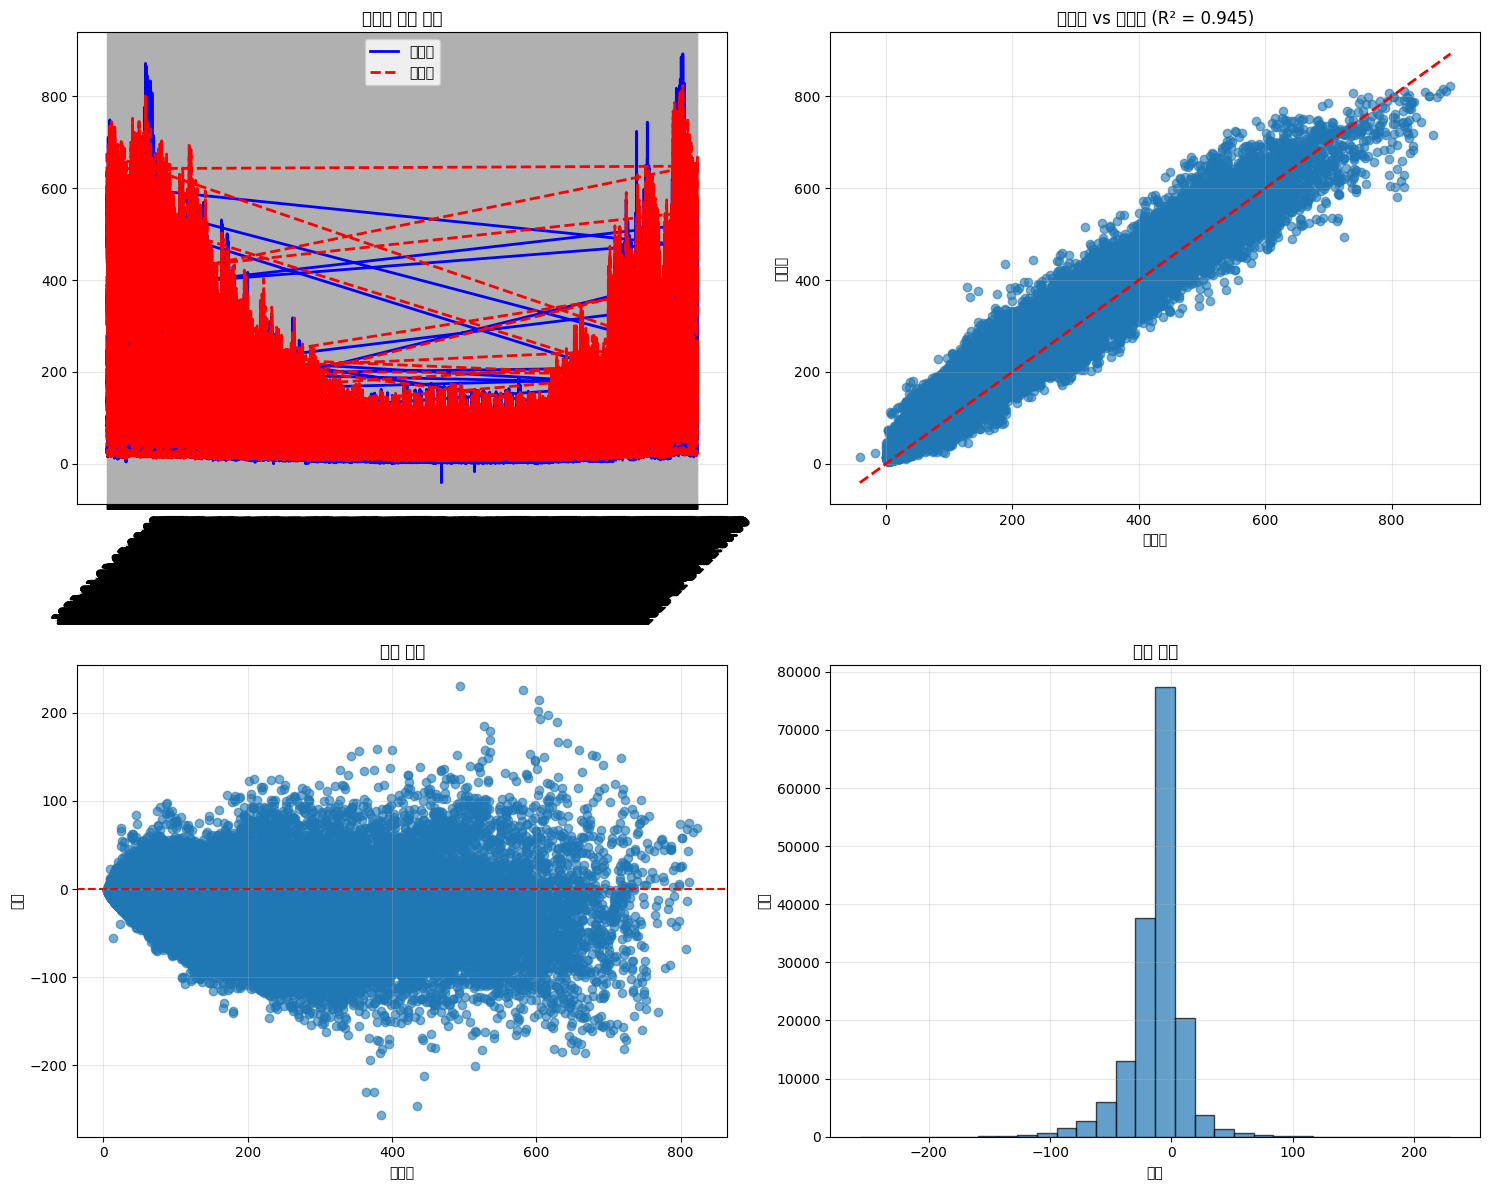

In [11]:
# 예측 결과 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 시계열 플롯
axes[0, 0].plot(test_data['tm'], actual, 'b-', label='실제값', linewidth=2)
axes[0, 0].plot(test_data['tm'], predictions, 'r--', label='예측값', linewidth=2)
axes[0, 0].set_title('시계열 예측 결과')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. 산점도
axes[0, 1].scatter(actual, predictions, alpha=0.6)
axes[0, 1].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('실제값')
axes[0, 1].set_ylabel('예측값')
axes[0, 1].set_title(f'실제값 vs 예측값 (R² = {r2:.3f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. 잔차 플롯
residuals = actual - predictions
axes[1, 0].scatter(predictions, residuals, alpha=0.6)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('예측값')
axes[1, 0].set_ylabel('잔차')
axes[1, 0].set_title('잔차 플롯')
axes[1, 0].grid(True, alpha=0.3)

# 4. 잔차 히스토그램
axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('잔차')
axes[1, 1].set_ylabel('빈도')
axes[1, 1].set_title('잔차 분포')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 특성 중요도 분석

In [12]:
# 특성 중요도 분석
feature_importance = predictor.feature_importance(test_dataset)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('특성 중요도')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

print("\n특성 중요도:")
print(feature_importance)

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	6038.52s	= Expected runtime (1207.7s per shuffle set)


KeyboardInterrupt: 

## 6. 모델 저장 및 불러오기

In [13]:
# 모델이 이미 저장되어 있음 (path='./autogluon_models'에서 지정)
print("모델이 './autogluon_models' 경로에 저장되었습니다.")

# 저장된 모델 불러오기 예시
# loaded_predictor = TabularPredictor.load('./autogluon_models')
# new_predictions = loaded_predictor.predict(test_features)

모델이 './autogluon_models' 경로에 저장되었습니다.


## 7. 결과 요약

In [16]:
print("=" * 50)
print("         모델링 결과 요약")
print("=" * 50)
print(f"학습 데이터: {len(train_dataset):,} 샘플")
print(f"테스트 데이터: {len(test_dataset):,} 샘플")
print(f"\n성능 지표:")
print(f"- RMSE: {rmse:.4f}")
print(f"- MAE: {mae:.4f}")
print(f"- R² Score: {r2:.4f}")
# print(f"\n최고 성능 모델: {leaderboard.index[0]}")
# print(f"최고 성능 점수: {leaderboard.iloc[0]['score_val']:.4f}")
print("=" * 50)

         모델링 결과 요약
학습 데이터: 332,861 샘플
테스트 데이터: 166,440 샘플

성능 지표:
- RMSE: 25.6636
- MAE: 17.3646
- R² Score: 0.9450


## 추가 팁과 개선 방안

### MICE 처리 개선 방안:
1. **시계열 특성 활용**: 시차(lag) 특성, 이동평균 등 추가
2. **도메인 지식 활용**: 계절성, 트렌드 등 시계열 패턴 고려
3. **교차 검증**: 시계열 교차 검증으로 MICE 파라미터 튜닝

### AutoGluon 최적화:
1. **시간 제한 조정**: `time_limit` 증가로 더 많은 모델 탐색
2. **앙상블 가중치**: `bag_folds`, `stack_ensemble_levels` 조정
3. **특성 엔지니어링**: 추가적인 시계열 특성 생성